In [2]:
pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


f:\ML\Women_safety\Women_Safety_venv_python_310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
f:\ML\Women_safety\Women_Safety_venv_python_310\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
f:\ML\Women_safety\Women_Safety_venv_python_310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6371 - loss: 1.0348 - val_accuracy: 0.5088 - val_loss: 0.7584
Epoch 2/50
 1/28 ━━━━━━━━━━━━━━━━━━━━ 8s 311ms/step - accuracy: 0.7031 - loss: 0.6754

f:\ML\Women_safety\Women_Safety_venv_python_310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7031 - loss: 0.6754 - val_accuracy: 0.5088 - val_loss: 0.7585
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - accuracy: 0.8244 - loss: 0.4251 - val_accuracy: 0.5088 - val_loss: 1.1768
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8438 - loss: 0.4452 - val_accuracy: 0.5088 - val_loss: 1.2822
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 359ms/step - accuracy: 0.8475 - loss: 0.4089 - val_accuracy: 0.5088 - val_loss: 1.8580
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8281 - loss: 0.4622 - val_accuracy: 0.5088 - val_loss: 1.7252
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - accuracy: 0.8407 - loss: 0.4030 - val_accuracy: 0.5088 - val_loss: 1.5286
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9062 - loss: 0.2677 - val_accuracy: 0.5088 - val_loss: 1.6279
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8590 - loss: 0.3725 - val_accuracy: 0.5088 - val_

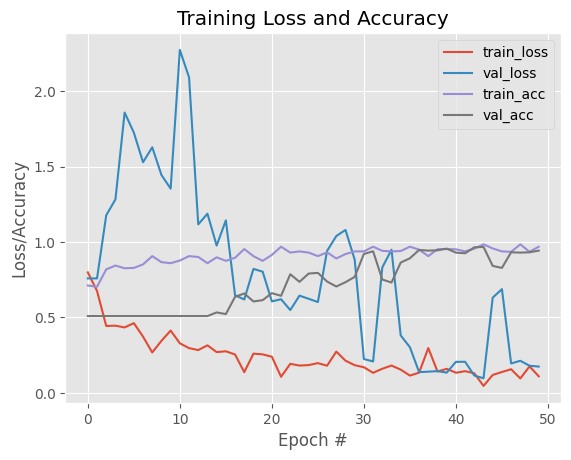

In [18]:
import os
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# ======================== INITIAL PARAMETERS ========================
epochs = 50
lr = 1e-3
batch_size = 64
img_dims = (96, 96, 3)

data = []
labels = []

# ======================== LOADING IMAGE DATASET ========================
dataset_path = 'gender_dataset_face'

# Load image files
image_files = [f for f in glob.glob(dataset_path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# Convert images to arrays & label them
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]  # Extracts "man" or "woman"
    label = 1 if label == "woman" else 0  # Assign labels
    labels.append(label)

# Convert to NumPy arrays
data = np.array(data, dtype="float32") / 255.0  # Normalize images
labels = np.array(labels)

# ======================== SPLIT DATASET ========================
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

# One-hot encode labels
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# ======================== DATA AUGMENTATION ========================
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest"
)

# ======================== BUILD CNN MODEL ========================
def build_model(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    # Layer 1
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # Layer 2
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    # Layer 3
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Layer 4
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    # Layer 5
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# ======================== COMPILE MODEL ========================
model = build_model(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

opt = Adam(learning_rate=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# ======================== TRAIN MODEL (WITH BATCH TRAINING) ========================
H = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // batch_size,
    epochs=epochs, verbose=1
)

# ======================== SAVE MODEL ========================
model.save('gender_detection.h5')

# ======================== PLOT TRAINING RESULTS ========================
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")  # Fixed 'acc' → 'accuracy'
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")  # Fixed 'val_acc'

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# Save plot
plt.savefig('training_plot.png')

# Show plot
plt.show()


In [19]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('gender_detection.h5')


In [20]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(testX, testY, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9505 - loss: 0.1552
Test Loss: 0.1741
Test Accuracy: 94.27%


In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predicted probabilities
predictions = model.predict(testX)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = np.argmax(testY, axis=1)

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=["Man", "Woman"]))

# Print confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
              precision    recall  f1-score   support

         Man       0.96      0.93      0.94       231
       Woman       0.93      0.96      0.94       223

    accuracy                           0.94       454
   macro avg       0.94      0.94      0.94       454
weighted avg       0.94      0.94      0.94       454

Confusion Matrix:
[[214  17]
 [  9 214]]


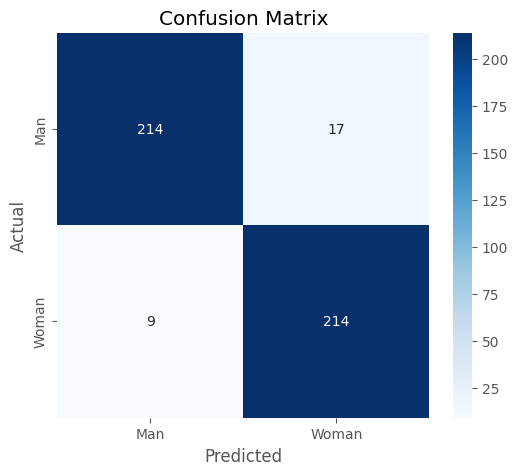

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d', xticklabels=["Man", "Woman"], yticklabels=["Man", "Woman"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os
import cvlib as cv
                    
# load model
model = load_model('gender_detection.model')

# open webcam
webcam = cv2.VideoCapture(0)
    
classes = ['man','woman']

# loop through frames
while webcam.isOpened():

    # read frame from webcam 
    status, frame = webcam.read()

    # apply face detection
    face, confidence = cv.detect_face(frame)


    # loop through detected faces
    for idx, f in enumerate(face):

        # get corner points of face rectangle        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)

        # crop the detected face region
        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue

        # preprocessing for gender detection model
        face_crop = cv2.resize(face_crop, (96,96))
        face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)

        # apply gender detection on face
        conf = model.predict(face_crop)[0] # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]

        # get label with max accuracy
        idx = np.argmax(conf)
        label = classes[idx]

        label = "{}: {:.2f}%".format(label, conf[idx] * 100)

        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, label, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                    0.7, (0, 255, 0), 2)

    # display output
    cv2.imshow("gender detection", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release resources
webcam.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'cvlib'

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load and compile the model
model = load_model("gender_detection.h5", compile=False)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Initialize the face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Open the webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Threshold for classification
threshold = 0.6

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Failed to capture frame.")
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]

        # Preprocess face
        face = cv2.resize(face, (96, 96))
        face = img_to_array(face)
        face = np.expand_dims(face, axis=0) / 255.0  # Normalize

        # Predict gender
        preds = model.predict(face)[0]

        # Apply threshold logic
        predicted_label = "Woman" if preds[1] > threshold else "Man"

        # Draw a rectangle
        color = (0, 255, 0) if predicted_label == "Man" else (255, 0, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)

        # Display prediction
        cv2.putText(frame, predicted_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show the frame
    cv2.imshow("Real-Time Gender Detection", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


Error: Failed to capture frame.


In [13]:
import random

# Select a random test image
idx = random.randint(0, len(testX) - 1)
test_image = testX[idx]
true_label = testY[idx]

# Preprocess and predict
pred = model.predict(np.expand_dims(test_image, axis=0))[0]
predicted_label = labels[np.argmax(pred)]

# Display results
print(f"True Label: {labels[np.argmax(true_label)]}")
print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
True Label: Man
Predicted Label: Man
